<h1> Evaluation (Graded Assignment) </h1>
Now that you have been introduced to different methods of plotting, processing and loading the raw data data. Please complete this evaluation on extending the 1D beamforming and 1D Matched Filter into 2D processing. We have provided data where we have taken wireless images of various objects and your goal is to figure out what we have imaged. Different students will be assigned different sets of data, which will be determiend at the time of evaluation. At the bottom of the notebook are a few questions to answer.

Your deliverables are:
1. Add the implementation of 2D beamforming
2. Add the implementation of 2D matched filter algorithm
3. Answer the 3 questions at the bottom of the notebook

(HINT: Use as a skeleton the code from exercise_2.ipynb)

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import scipy.io as sio
import processing.save_adc_data as sd
import processing._process_data as pd

Load the given data.

In [112]:
# TODO: Put the *path* to the project folder
home_dir = r"/Users/jacopoferro/Documents/CommProject/comm-proj-radar"

# loading data that is given
filename = r"data_005"
data_dir = r"data"
mat_data = sio.loadmat(os.path.join(home_dir,data_dir,filename + '.mat'))
raw_data = mat_data['adcData']
num_x_stp, num_z_stp, num_tx, num_rx, adc_samples = raw_data.shape
X = raw_data

print("Data shape:  ", X.shape)
print("num_x_stp:   ", num_x_stp)
print("num_z_stp:   ", num_z_stp)
print("num_tx:      ", num_tx)
print("num_rx:      ", num_rx)
print("adc_samples: ", adc_samples)


Data shape:   (80, 369, 1, 4, 512)
num_x_stp:    80
num_z_stp:    369
num_tx:       1
num_rx:       4
adc_samples:  512


Sanity Check on the data: 
ADC Samples of Signal as complex number at position (0,0): 
 [1924.   +9.j 1889. +626.j -114.+1324.j -205.  -57.j  694.-1952.j
 1696.  -75.j 1799.+1286.j  342. +199.j  763.  +49.j 2036. +486.j] ...
 [ -508.+1000.j  -817.+1332.j  -705. +700.j  -485.+1082.j -1691.+2085.j
 -1754. -199.j  -410. -355.j  -384.+1217.j -1178. +603.j    94.  +39.j]


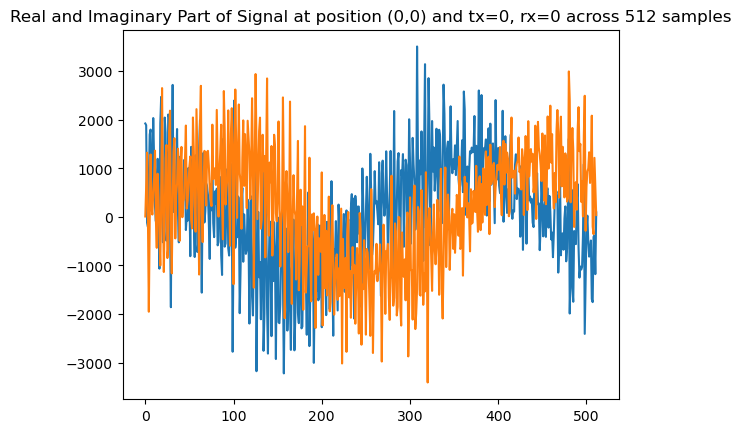

In [113]:
# Let's visualize a bit the architecture of this SAR system
# From my understanding so far, we have the following:
# num_x_stp: number of steps in the x direction (horizontal, moving to the right) = 80
# num_z_stp: number of steps in the z direction (vertical, moving upwards) = 369
# num_tx: number of transmitters = 1
# num_rx: number of receivers = 4
# adc_samples: number of samples taken by the ADC in each position = 512

# So, regardeless of exact time (SAR, not MIMO now), we should just care about those 512 samples in the virtual grid of 80x369
# In particular at each point in the grid we send a signal and receive 4 signals back, which are sampled 512 times
# It's not 100% clear to me if we dropped the notion of frame and chirp, but I think we did, we just care about the 512 adc samples at each position

print("Sanity Check on the data: ")
print("ADC Samples of Signal as complex number at position (0,0): \n", X[0,0,0,0,:10], "...\n" , X[0,0,0,0,-10:])
signal_example = X[0,0,0,0,:]
plt.plot(np.real(signal_example))
plt.plot(np.imag(signal_example))
plt.title("Real and Imaginary Part of Signal at position (0,0) and tx=0, rx=0 across 512 samples")
plt.show()

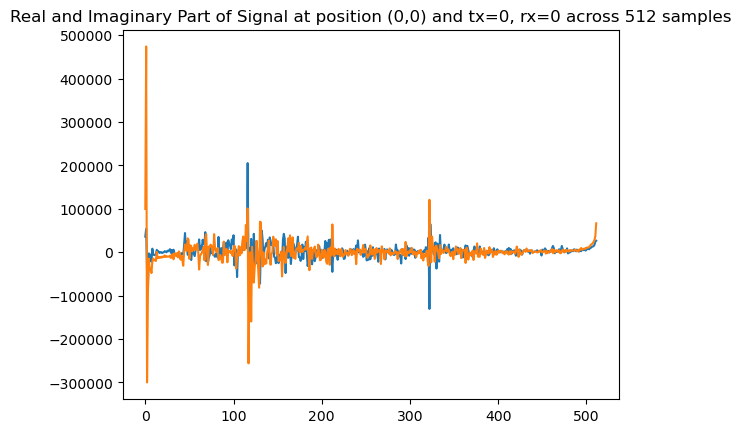

In [114]:
# fft 
signal_example_fft = np.fft.fft(signal_example)
plt.plot(np.real(signal_example_fft))
plt.plot(np.imag(signal_example_fft))
plt.title("Real and Imaginary Part of Signal at position (0,0) and tx=0, rx=0 across 512 samples")
plt.show()

In [115]:
# The above is just a sanity check and a bit of playing around, not useful, we'll do a proper range fft and beamforming now

Here you should finish defining the antenna locations. We are using the same data as before, so the x-positions will be the same. However, in this case you also need to define the z-locations.  

In [116]:
# define the antenna spacing
#lm = 3e8/77e9 # define lambda for the antenna spacing
# rx_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) / 2
# x_pos = (np.reshape(np.arange(1,81,dtype=float),(-1,1)) * lm).T
# #x_pos = np.reshape(rx_pos.T * x_pos.T ,(-1,1)) # wrong 
# x_pos = np.reshape(np.array([rx_pos + x_pos[i] for i in range(len(x_pos))]),(-1,1))
# z_pos = 0 # TODO: fill in z locations of the antenna spacing (vertical spacing) 
# # specification is written in next markdown cells: we move horizontally by lambda/2 in 80 steps and vertically by 300*lambda/4/369 in 369 steps
# # So, here we need to keep in mind: 'digital grid' of 80x369, where we move horizontally by lambda/2 and vertically by 300*lambda/4/369
# #z_pos = np.re
# # honestly doing one step at a time wouldve been less confusing: 
# # relative to origin rx and tx
# # then grid 80x369, 
# # then spacing lambda/2 horizontally and 300*lambda/4/369 vertically, which now is basically alligned with the single transmitter
# # then finding the actual receiver (antennas) positions by multiplying the grid by the relative to origine rx and tx positions


# rx_pos = -np.reshape(np.arange(0,4,dtype=float),(-1,1)) * lm / 2
# x_pos = (np.reshape(np.arange(0,80,dtype=float),(-1,1)) * lm)
# ant_pos = np.reshape(np.array([rx_pos + x_pos[i] for i in range(len(x_pos))]),(-1,1))
# z_pos =  (np.reshape(np.arange(0,369,dtype=float),(-1,1)) * 300*lm/4/369)
# # So:
# # 1. relative to origin rx and tx
# rx_relative_pos = np.reshape(np.arange(1,5,dtype=float),(-1,1)) / 2
# tx_relative_pos = 0
# print("Relative to origin rx and tx positions:\n", rx_relative_pos, tx_relative_pos)

# # 2. grid 80x369
# x_pos = np.arange(1,81,dtype=float)
# z_pos = np.arange(1,370,dtype=float)
# print("Grid 80x369:\n", x_pos.shape, z_pos.shape)

# # 3. spacing lambda/2 horizontally and 300*lambda/4/369 vertically # NOPE, just lambda..... why is it such a mess
# # so it's not like hw1, we are moving by lambda....
# x_pos = x_pos * lm / 2
# z_pos = z_pos * 300 * lm / 4 / 369
# print("Spacing lambda/2 horizontally and 300*lambda/4/369 vertically:\n", x_pos.shape, z_pos.shape)

# # "In other words, we are moving the radar a step size of lambda each time and the antenna’s are spaced 
# # [0, -lambda/2, -lambda, -3lambda/2], so we expect the overall spacing to be like: 
# #  [0, -lambda/2, -lambda, -3lambda/2, lambda, lambda/2, 0, -lambda/2,  2lambda, 3lambda/2, lambda, lambda/2,….]."



# # Note again as sanity check:
# # lm is lambda = c/f = 3e8/77e9
# # rx_pos is the position of the receivers, which are 4 and are spaced by lambda/2
# # rx_pos is calculated simply by creating the array [1,2,3,4] and dividing by 2 (to get lambda/2)
# print("Receiver positions reference:", rx_pos.shape,'\n', rx_pos)
# print("Antennas (Receivers) positions along x:", x_pos.shape,'\n',  x_pos[:5], '\n ...\n', x_pos[-1:])
# print("Antennas (Receivers) positions along z:", z_pos.shape,'\n',  z_pos[:5], '\n ...\n', z_pos[-1:])

# ===========
# ===========

lm = 3e8/77e9 

rx_pos = -np.reshape(np.arange(0,4,dtype=float),(-1,1)) * lm / 2
print("Receiver positions reference:", rx_pos.shape,'\n', rx_pos)

x_pos = (np.reshape(np.arange(0,80,dtype=float),(-1,1)) * lm)
print("Transmitters positions along x:", x_pos.shape,'\n',  x_pos[:5], '\n ...\n', x_pos[-1:])

ant_pos = np.reshape(np.array([rx_pos + x_pos[i] for i in range(len(x_pos))]),(-1,1))
print("Antennas (Receivers) positions along x:", ant_pos.shape,'\n',  ant_pos[:5], '\n ...\n', ant_pos[-1:])

z_pos =  (np.reshape(np.arange(0,369,dtype=float),(-1,1)) * 300*lm/4/369)
print("Antennas (Receivers) positions along z:", z_pos.shape,'\n',  z_pos[:5], '\n ...\n', z_pos[-1:])


Receiver positions reference: (4, 1) 
 [[-0.        ]
 [-0.00194805]
 [-0.0038961 ]
 [-0.00584416]]
Transmitters positions along x: (80, 1) 
 [[0.        ]
 [0.0038961 ]
 [0.00779221]
 [0.01168831]
 [0.01558442]] 
 ...
 [[0.30779221]]
Antennas (Receivers) positions along x: (320, 1) 
 [[ 0.        ]
 [-0.00194805]
 [-0.0038961 ]
 [-0.00584416]
 [ 0.0038961 ]] 
 ...
 [[0.30194805]]
Antennas (Receivers) positions along z: (369, 1) 
 [[0.        ]
 [0.00079189]
 [0.00158378]
 [0.00237567]
 [0.00316756]] 
 ...
 [[0.2914159]]


Perform range FFT on raw ADC data.

In [117]:
# reformat the data so that it matches the antenna locations
X = np.reshape(np.transpose(np.squeeze(X),(0,2,1,3)),(num_x_stp * num_rx, num_z_stp, adc_samples)) 
beat_freq = np.squeeze(scipy.fft.fft(X, axis=-1))

X shape:  (320, 369, 512)
beat_freq shape:  (320, 369, 512)


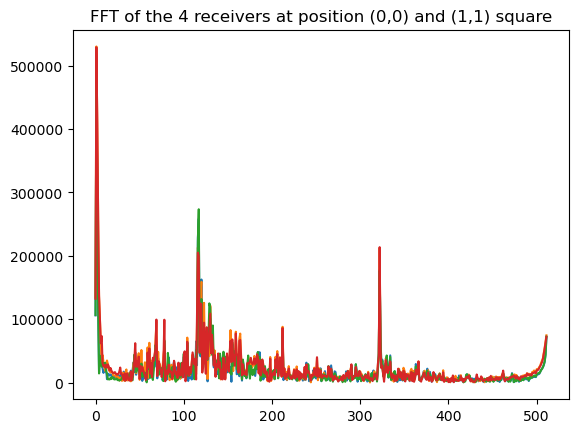

In [118]:
print("X shape: ", X.shape)
print("beat_freq shape: ", beat_freq.shape)
# quick viz 
plt.figure()
plt.plot(np.abs(beat_freq[0,0,:]))
plt.plot(np.abs(beat_freq[1,0,:]))
plt.plot(np.abs(beat_freq[0,1,:]))
plt.plot(np.abs(beat_freq[1,1,:]))
plt.title("FFT of the 4 receivers at position (0,0) and (1,1) square")
plt.show()

Text(0.5, 1.0, 'Range Profile')

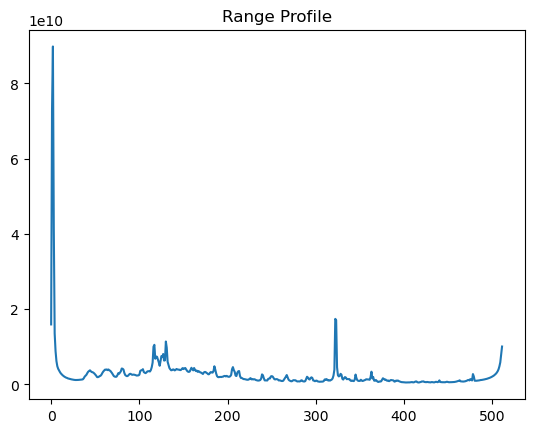

In [119]:
# plot the range profile
range_profile = np.sum(np.abs(beat_freq),axis=(0,1))
plt.figure()
plt.plot(range_profile)
plt.title("Range Profile")

<h5> 1. 2D Beamforming: </h5>
Implement your version of 2D beamforming below. The antenna array is 4x80 along the x-dimension and 369 along the z-dimension (vertical), with the antenna spacing a long the vertical direction as (300*lm/4/369). This is the same formulation as shown in *exercise_2.ipynb*. The bins you should compute the azimuth and elevation angles are for <check with TA>. 

To start with, we recommend copying the implementation details from 1D and simply extend the calculations to include the elevation (z) information. 

In [120]:
import time
def steering_vec(theta,locs):
    '''
    Calculates the steering vector based on the angle given (theta) and the antenna array locations. 
    
    Paramters: 
    - theta: angle of arrival that we are calculating the steering vector for (radians)
    - locs: antenna locations

    Returns:
    - bf_vector: steering vector
    '''


    cos_theta = np.cos(theta) # angle that the signal is coming from 
    bf_vector = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))

    return bf_vector

def beamform_1d(beat_freq_data, theta_s, theta_e,theta_res,locs):
    """
    Performs 1D beamforming along the azimuth (horizontal) dimension, this results in a bird eye view image.

    Paramters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
    - theta_s: first angle that you want to start computing 
    - theta_e: last angle that you want to compute 
    - theta_res: resolution of the angles you want to compute
    - locs: antenna locations

    Returns:
    - sph_pwr: beamformed result
    - theta: the array of the angles computed
    """
    # Convert everything to Radians 
    theta_s_r = theta_s * (np.pi/180)
    theta_e_r = theta_e * (np.pi/180)
    theta_res*= (np.pi/180)
    theta_rad_lim = [theta_s_r,theta_e_r]

    # Generate arrays for theta 
    theta = np.arange(theta_rad_lim[0], theta_rad_lim[1], theta_res)
    N_theta = len(theta)

    # Initialize arrays for spherical power
    sph_pwr = np.zeros((N_theta, adc_samples), dtype=complex)

    print("Running this many iterations: %d " % (N_theta))

    ######################## BF Calculations ###########################3
    for kt in range(N_theta):
        start_time = time.time()
        Vec = steering_vec(theta[kt],locs)
        # Vec = np.exp(1j*(2*np.pi*(locs*cos_theta)/lm))
        VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1))
        sph_pwr[kt, :] = np.squeeze(np.sum(np.multiply(np.squeeze(beat_freq_data),VecRFI), axis=(0)))        
        print("Processed angle (%.2f) took %.2f sec" % (theta[kt]*180/np.pi, start_time - time.time()), end='\r')
    return sph_pwr, theta

# def beamform_2d():
#     # TODO: implement your function here
#     # beamforming
    

#     return

#def steering_vec_2d(theta, phi, locs, lm): # basically was in slides
def steering_vec_2d(theta, phi, x_locs, z_locs , lm):
    """
    Calculates the steering vector based on the azimuth and elevation angles given and the antenna array locations.

    Parameters:
    - theta: azimuth angle of arrival that we are calculating the steering vector for (radians)
    - phi: elevation angle of arrival that we are calculating the steering vector for (radians)
    - locs: antenna locations (x, z)
    - lm: wavelength of the signal

    Returns:
    - bf_vector: steering vector
    """
    print("Calculating steering vector for theta=%.2f, phi=%.2f" % (theta, phi))
    #print("Antenna locations: ", locs[0].shape, locs[1].shape)
    print("Antenna locations: ", x_locs.shape, z_locs.shape)
    cos_theta = np.cos(theta)
    cos_phi = np.cos(phi)
    sin_theta = np.sin(theta)
    sin_phi = np.sin(phi)

    # x_locs = locs[0]
    # z_locs = locs[1]
    

    # Calculate the steering vector
    #bf_vector = np.exp(1j * (2 * np.pi * (x_locs * cos_theta * sin_phi + z_locs * sin_theta * sin_phi) / lm))
    #bf_vector = np.exp(1j * (2 * np.pi * (x_locs * cos_theta + z_locs * sin_theta) / lm))
    #operands could not be broadcast together with shapes (80,1) (369,1) (or 320 and 369)
    # wave vector 
    k = np.pi * 2 / lm 
    # wave vector components
    kx = cos_theta * sin_phi
    #ky = sin_theta * sin_phi
    kz = sin_theta * sin_phi

    #phase shift
    # phase_shift = kx * x_locs + kz * z_locs
    # bf_vector = np.exp(1j * k * phase_shift)
    bf_vector = np.outer(np.exp(1j * k * (kx * x_locs)), np.exp(1j * k * (kz * z_locs)))



    return bf_vector

# def beamform_2d(beat_freq_data, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, locs, lm, adc_samples):
#     """
#     Performs 2D beamforming over azimuth (theta) and elevation (phi) dimensions.

#     Parameters:
#     - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
#     - theta_s, theta_e, theta_res: start angle, end angle, and resolution for azimuth
#     - phi_s, phi_e, phi_res: start angle, end angle, and resolution for elevation
#     - locs: antenna locations
#     - lm: wavelength of the signal
#     - adc_samples: number of ADC samples

#     Returns:
#     - sph_pwr_2d: beamformed result in 2D
#     - theta, phi: the arrays of the computed azimuth and elevation angles
#     """
#     print("Running 2D Beamforming")
#     print("Azimuth: %.2f to %.2f with resolution %.2f" % (theta_s, theta_e, theta_res))
#     print("Elevation: %.2f to %.2f with resolution %.2f" % (phi_s, phi_e, phi_res))
#     print("Positions of the antennas: ", locs.shape)
#     print("Number of ADC samples: %d" % adc_samples)


#     # Conversion to radians and initialization
#     theta_s_r, theta_e_r = theta_s * (np.pi/180), theta_e * (np.pi/180)
#     phi_s_r, phi_e_r = phi_s * (np.pi/180), phi_e * (np.pi/180)
#     theta = np.arange(theta_s_r, theta_e_r, theta_res * (np.pi/180))
#     phi = np.arange(phi_s_r, phi_e_r, phi_res * (np.pi/180))
#     N_theta, N_phi = len(theta), len(phi)

#     # Initializing the 2D spherical power matrix
#     sph_pwr_2d = np.zeros((N_theta, N_phi, adc_samples), dtype=complex)

#     # Beamforming Calculations # algo in slides, won't be super fast but whatever
#     for kt in range(N_theta):
#         for kp in range(N_phi):
#             start_time = time.time()
#             # Steering vector for current theta and phi
#             Vec = steering_vec_2d(theta[kt], phi[kp], locs, lm) 
#             VecRFI = np.squeeze(np.repeat(Vec[:, np.newaxis], adc_samples, axis=1)) 
#             # Accumulate power for this direction
#             sph_pwr_2d[kt, kp, :] = np.sum(np.multiply(beat_freq_data, VecRFI), axis=(0, 1))
#             print("Processed angle (%.2f) took %.2f sec" % (theta[kt]*180/np.pi, start_time - time.time()), end='\r')
    
#     return sph_pwr_2d, theta, phi

#def beamform_2d(beat_freq_data, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, locs, lm, adc_samples):
def beamform_2d(beat_freq_data, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, x_locs, z_locs, lm, adc_samples):
    """
    Performs 2D beamforming over azimuth (theta) and elevation (phi) dimensions.

    Parameters:
    - beat_freq_data: beat data AKA the range FFT (size: num TX * num RX, num ADC samples)
    - theta_s, theta_e, theta_res: start angle, end angle, and resolution for azimuth
    - phi_s, phi_e, phi_res: start angle, end angle, and resolution for elevation
    #- locs: antenna locations (x, z)
    - x_pos: x positions of the antennas
    - z_pos: z positions of the antennas # otherwise broadcasting priblems
    - lm: wavelength of the signal
    - adc_samples: number of ADC samples

    Returns:
    - sph_pwr_2d: beamformed result in 2D
    - theta, phi: the arrays of the computed azimuth and elevation angles
    """
    # Convert angles from degrees to radians and generate angle arrays
    theta_s, theta_e = np.radians(theta_s), np.radians(theta_e)
    phi_s, phi_e = np.radians(phi_s), np.radians(phi_e)
    
    theta = np.arange(theta_s, theta_e, np.radians(theta_res))
    phi = np.arange(phi_s, phi_e, np.radians(phi_res))

    # Print the total number of iterations
    print("Running this many iterations: %d " % (len(theta) * len(phi)))
    
    # Initialize the output data array
    N_theta, N_phi = len(theta), len(phi)
    beamformed_data = np.zeros((N_theta, N_phi, beat_freq_data.shape[2]), dtype=complex)  # Assuming last dimension is range bins
    
    ######################## BF Calculations ###########################
    for i, t in enumerate(theta):
        for j, p in enumerate(phi):
            start_time = time.time()
            # Calculate steering vector for current angle combination
            Vec = steering_vec_2d(t, p, x_locs, z_locs, lm)
            VecRFI = np.repeat(Vec[:, np.newaxis], beat_freq_data.shape[2], axis=1)
            VecRFI = VecRFI.reshape((beat_freq_data.shape[0], beat_freq_data.shape[1], beat_freq_data.shape[2]))
            
            # Apply beamforming for the current angle, summing over the antenna dimensions
            beamformed_data[i, j, :] = np.sum(beat_freq_data * VecRFI, axis=(0, 1))  # Sum over both antenna dimensions
            
            # Print processing time for this cell
            print("Processed cell (%.2f,%.2f) took %.2f sec" % (np.degrees(t), np.degrees(p), time.time() - start_time), end='\r')
            
    return beamformed_data, theta, phi

Plot the 2D slice here.

Running this many iterations: 2440 
Calculating steering vector for theta=1.22, phi=-0.35
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.33
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.31
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.30
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.28
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.26
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.24
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.23
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.21
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, phi=-0.19
Antenna locations:  (320, 1) (369, 1)
Calculating steering vector for theta=1.22, 

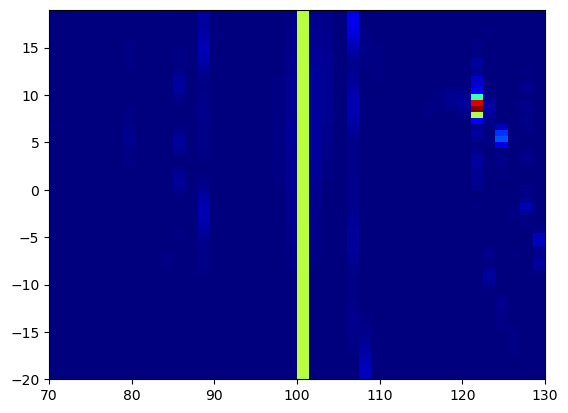

In [121]:
# TODO: plot your output here
# theta_s, theta_e = 70, 130
# theta_res = 1
# phi_s, phi_e = -20, 20
# phi_res = 1
# ant_pos = X
# sph_pwr_2d, theta, phi = beamform_2d(beat_freq, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, ant_pos, lm, adc_samples)


theta_s, theta_e = 70, 130
phi_s, phi_e = -20, 20
theta_res, phi_res = 1, 1 
#locs = (ant_pos, z_pos)


#bf_output_2d, theta, phi = beamform_2d(beat_freq, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, x_pos, z_pos, lm, adc_samples)
bf_output_2d, theta, phi = beamform_2d(beat_freq, theta_s, theta_e, theta_res, phi_s, phi_e, phi_res, ant_pos, z_pos, lm, adc_samples)

# range bins
selected_bins = bf_output_2d[:, :, 100:140]
slice_2d = np.mean(selected_bins, axis=2)
normalized_slice = np.abs(slice_2d)**2
normalized_slice = normalized_slice / np.max(normalized_slice)

# Plotting
theta_deg = np.degrees(theta)  
phi_deg = np.degrees(phi)
plt.imshow(normalized_slice, extent=[theta_deg[0], theta_deg[-1], phi_deg[0], phi_deg[-1]], aspect='auto', cmap='jet')

In [ ]:
# plot_lim_y = [0, 369 * 300 * lm / 4]
# plot_lim_x = [70 - theta_s,129 - theta_s]
# to_plot = sph_pwr_2d[:,0,:]
# plt.imshow(np.abs(to_plot), aspect='auto', extent=[plot_lim_x[0],plot_lim_x[1],plot_lim_y[0],plot_lim_y[1]])


<h5> 2. 2D Matched Filter: </h5>
Implement your version of 2D matched filtering below. The antenna array is same as above, and the depths you should calculate are <check with TA>.

In [126]:
# def MF_2d():
#     # TODO: implement your function here
#     return

######## 1D Imaging in Cartesian #############
def matched_filter_1d(raw_data_1d, num_x_cells, num_y_cells, x_radar_tx, x_radar_rx):
    """
    Computes the 1D matched filter result for raw data, this is done along the X, Y dimensions (results in a birds eye view image).

    Paramters:
    - raw_data_1d: raw ADC data (size: num Tx * num Rx, num ADC samples)
    - num_x_cells: discrete locations in X (horizontal) that you want to compute the power of
    - num_y_cells: discrete locations in Y (range/depth) that you want to compute the power of
    - x_radar_tx: positions of the transmitters 
    - x_radar_rx: positions of the receivers 

    Returns:
    - MF_output: matched filter output
    """
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)

    MF_output = np.zeros((len(num_x_cells),len(num_y_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for j,cell_y in enumerate(num_y_cells):
                start_time = time.time()

                cell_dist = np.sqrt((x_radar_tx - cell_x)**2 + (cell_y)**2) + np.sqrt((cell_x - x_radar_rx)**2 + (cell_y)**2)                
                cell_dist = cell_dist + 0.15 # account for range bias
                temp_tau = (cell_dist)/c
                
                temp_sig_phase = 2.0*np.pi*fc_start*temp_tau
                total_phase = np.repeat(temp_sig_phase,adc_samples,axis=1) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau
                temp_real = np.cos(total_phase)
                temp_imag = -np.sin(total_phase)
                MF_output[i,j] = MF_output[i,j] + np.sum((raw_data_1d *  (temp_real + temp_imag*1j)),axis=(0,1))
                            
                print("Processed cell (%.2f,%.2f) took %.2f sec" % (cell_x,cell_y, start_time - time.time()), end='\r')
    return MF_output 

def MF_2d(raw_data_2d, num_x_cells, num_z_cells, num_y_cells, x_radar_tx, x_radar_rx, z_radar_tx, z_radar_rx):
    """
    Computes the 1D matched filter result for raw data, this is done along the X, Y dimensions (results in a birds eye view image).

    Paramters:
    - raw_data_1d: raw ADC data (size: num Tx * num Rx, num ADC samples)
    - num_x_cells: discrete locations in X (horizontal) that you want to compute the power of
    - num_y_cells: discrete locations in Y (range/depth) that you want to compute the power of
    - x_radar_tx: positions of the transmitters 
    - x_radar_rx: positions of the receivers 

    Returns:
    - MF_output: matched filter output
    """
    c = 2.9979
    fc_start =  773.704
    chirpSlope = 70.295e12
    adcSampleRate = 10e6
    As_sci = (chirpSlope/1e8)
    x_radar_tx = np.squeeze(x_radar_tx)
    z_radar_tx = np.squeeze(z_radar_tx)
    x_radar_rx = np.squeeze(x_radar_rx)
    z_radar_rx = np.squeeze(z_radar_rx)

    MF_output = np.zeros((len(num_x_cells),len(num_z_cells)),dtype=complex)

    for i,cell_x in enumerate(num_x_cells):
        for k,cell_z in enumerate(num_z_cells):
            for j,cell_y in enumerate(num_y_cells):
                    start_time = time.time()
                    # clunky but quite literal implementation of distance calculation
                    cell_dist = np.sqrt(np.add.outer((x_radar_tx - cell_x)**2 + (cell_y)**2, (z_radar_tx - cell_z)**2)) + np.sqrt(np.add.outer((x_radar_rx - cell_x)**2 + (cell_y)**2, (z_radar_rx - cell_z)**2))
                                    
                    cell_dist = cell_dist + 0.15 # account for range bias
                    temp_tau = (cell_dist)/c # time of arrival difference wrt transmit theoretical time of arrival
                    
                    phase = np.expand_dims(2.0*np.pi*fc_start*temp_tau, axis=2)
                    total_phase = np.repeat(phase,adc_samples,axis=2) + 2.0 * np.pi * As_sci * (np.arange(0,adc_samples).T / adcSampleRate) * temp_tau[:,:,np.newaxis]
                    temp_real = np.cos(total_phase)
                    temp_imag = -np.sin(total_phase)
                    # we just do in 2D to create an image even tho we could store a 3D matrix and maybe do blobs or point clouds or some extra fancy summation
                    MF_output[i,k] = MF_output[i,k] + np.sum((raw_data_2d *  (temp_real + temp_imag*1j)),axis=(0,1,2))
                                
                    print("Processed cell (%.2f,%.2f) took %.2f sec" % (cell_x,cell_z, start_time - time.time()), end='\r')
    return MF_output 


Plot your 2D slices here.

In [124]:
# TODO: plot your output here
X = np.squeeze(raw_data[:,:,:,:,:]) 
X = np.transpose(X, (0, 2, 1, 3))
X = np.reshape(X,(-1,num_z_stp,adc_samples))

num_x_cells = np.arange(-0.7,0.23,0.05)
num_z_cells = np.arange(-0.25,0.74,0.05)
num_y_cells = np.arange(4.915,4.916,0.05)

x_radar_tx = ant_pos - 0.005 - 3 * lm / 2
x_radar_rx = ant_pos

z_radar_tx = z_pos
z_radar_rx = z_pos


MF_output = MF_2d(X, num_x_cells, num_z_cells, num_y_cells, x_radar_tx, x_radar_rx, z_radar_tx, z_radar_rx)


(3428318.4918308253+6422667.337363566j)

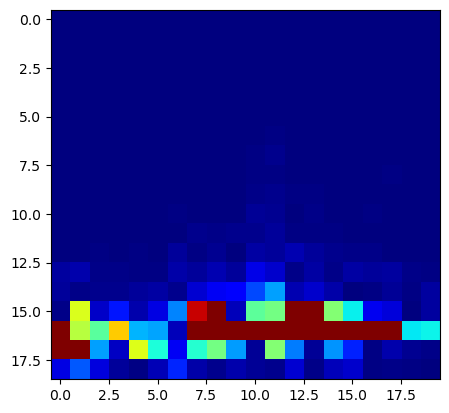

In [125]:
MF_output.shape
to_plot = MF_output/np.max(np.reshape(MF_output,(1,-1)))
to_plot = to_plot[:,:]**2
plt.imshow(abs(to_plot),cmap = 'jet',  vmin=0, vmax=0.3)
MF_output[5,6]

In [127]:
# it's the Taaj Mahal, but let's add some resolution:
num_x_cells = np.arange(-0.7,0.23,0.02)
num_z_cells = np.arange(-0.25,0.74,0.05)
num_y_cells = np.arange(4.916,4.918,0.05)


x_radar_tx = ant_pos - 0.005 - 3 * lm / 2
x_radar_rx = ant_pos

z_radar_tx = z_pos
z_radar_rx = z_pos


MF_output = MF_2d(X, num_x_cells, num_z_cells, num_y_cells, x_radar_tx, x_radar_rx, z_radar_tx, z_radar_rx)

(825417.6914929879-441449.28221400036j)

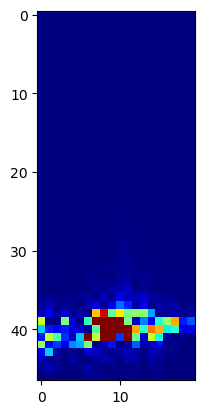

In [128]:
MF_output.shape
to_plot = MF_output/np.max(np.reshape(MF_output,(1,-1)))
to_plot = to_plot[:,:]**2
plt.imshow(abs(to_plot),cmap = 'jet',  vmin=0, vmax=0.3)
MF_output[5,6]

Now answer the following questions pertaining to your results. 

Question 1: Look through the possible objects that have been imaged, and match your output to one of these objects. Write the object below:

The various plots / images show that the object is the sculpture / model of the Taj Mahal. By running again the analysis with finer details (more time consuming, more accurate) we can see it better.

Question 2: Which image looks more realistic, beamforming or matched filter?

Matched filter. It also takes more time to compute even tho we could push both quite a bit more.

Question 3: Explain the reason for one processing algorithm to produce better images than the other.

Two different approaches of analyzing the data. Beamforming is about moving to frequency domain. The algo implementation was naive but it can be implemented much faster and more accurately. It mainly leverages the AoA of the signal. Matched filter is about comparing the received signal with a known/theoretical signal, or better it's expected response in time and frequency. It is more accurate but also more time consuming, it also require us to select a very precise region in space and compute all the necessary differences and distances inside a gid in that region. It leverages the cross-correlation of the signal.

We can imagine how they can both serve different scenarios. In this case we could actually use matched filter as a faster, initial coarse view to create a 3D point cloud blob scene, then we could narrow down for 3D imaging. 